In [1]:
from huggingface_hub import notebook_login
 
notebook_login()

In [1]:
import json
import os
import warnings

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from peft import PeftConfig, PeftModel

from fastchat.utils import get_gpu_memory, is_partial_stop, is_sentence_complete, get_context_length
from fastchat.conversation import get_conv_template, register_conv_template, Conversation, SeparatorStyle
from fastchat.serve.inference import generate_stream

warnings.filterwarnings('ignore')

[2023-12-02 19:17:25,949] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [5]:
SYSTEM_MSG = """Your name is Zen and you're an AI mental health counselor. Please have a conversation with your patient and provide them with a helpful response to their concerns."""

try:
    register_conv_template(
        Conversation(
            name="Zen",
            system_message=SYSTEM_MSG,
            roles=("USER", "ASSISTANT"),
            sep_style=SeparatorStyle.ADD_COLON_TWO,
            sep=" ",
            sep2="</s>",
        )
    )
except AssertionError:
    pass

In [3]:
def load_model(model_path, num_gpus, base_model_path=None, max_gpu_memory=None):
    
    kwargs = {"torch_dtype": torch.float16}
    if num_gpus != 1:
        kwargs["device_map"] = "auto"
        if max_gpu_memory is None:
            kwargs[
                "device_map"
            ] = "sequential"  # This is important for not the same VRAM sizes
            available_gpu_memory = get_gpu_memory(num_gpus)
            kwargs["max_memory"] = {
                i: str(int(available_gpu_memory[i] * 0.85)) + "GiB"
                for i in range(num_gpus)
            }
        else:
            kwargs["max_memory"] = {i: max_gpu_memory for i in range(num_gpus)}
        
        if base_model_path is None:
            config = PeftConfig.from_pretrained(model_path)
            base_model_path = config.base_model_name_or_path
            
        tokenizer = AutoTokenizer.from_pretrained(
            base_model_path, use_fast=False
        )
        model = AutoModelForCausalLM.from_pretrained(
            base_model_path,
            low_cpu_mem_usage=True,
            **kwargs,
        )
        if base_model_path is None:
            model = PeftModel.from_pretrained(model, model_path)
        
        return model, tokenizer

In [4]:
import os
import pandas as pd
import pickle
import re

from tqdm.notebook import tqdm

DATA_DIR = "../data/"

df_path = os.path.join(DATA_DIR, "llm_responses.csv")
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
else:
    with open(os.path.join(DATA_DIR, "test.p"), "rb") as f:
        test = pickle.load(f)

    df = pd.DataFrame(columns=["orig_prompt"], data=test)
    df["answer"] = df.orig_prompt.apply(lambda x: re.findall(r'ASSISTANT: (.*?)</s>', x, re.DOTALL)[-1].strip())
    df.to_csv(df_path, index=False)
    
df.head()

,orig_prompt,answer,Zen,llama-2,vicuna_v1.1
0,Your name is Zen and you're a mental health co...,It's common to experience low self-esteem at t...,I'm sorry to hear that you're struggling with ...,<</SYS>>\n\nI understand how you feel. It's im...,I'm sorry to hear that you're struggling with ...
1,Your name is Zen and you're a mental health co...,You too! If you have any concerns or questions...,You too!,[IST]\n<b>My name is</b>\n^i6\n\n[/IST]\n[INST...,"Thank you, have a nice day as well! Is there a..."
2,Your name is Zen and you're a mental health co...,It's understandable that you may have difficul...,Thank you for sharing that with me. It takes a...,<</SYS>>\n\nYou're right not to trust people. ...,I understand that it can be difficult to trust...
3,Your name is Zen and you're a mental health co...,Maintaining a healthy work-life balance is imp...,"I see how that can be challenging, and it's im...",<</SYS>>\n\n**Zen** I understand that you're f...,I understand how you feel. It can be challengi...
4,Your name is Zen and you're a mental health co...,It's important to communicate openly and hones...,Thank you for reaching out. It's important to ...,<<S>> I'm sorry to hear that. What kind of arg...,I'm sorry to hear that you're having trouble w...


In [5]:
def get_conv(text, conv_template):
    conv = get_conv_template(conv_template)
    conv.messages = []
    conv.set_system_message(SYSTEM_MSG)
    
    q = re.findall(r'USER: (.*?) ASSISTANT:', text, re.DOTALL)
    a = re.findall(r'ASSISTANT: (.*?)</s>', text, re.DOTALL)
    assert len(q) == len(a)
    
    # conv.append_message(conv.roles[0], "Hello! I'm Manish!")
    # conv.append_message(conv.roles[1], "Hello Manish! How can I help you today?")
    
    for i in range(len(q)):
        conv.append_message(conv.roles[0], q[i].strip())
        
        if i == len(q) - 1:
            conv.append_message(conv.roles[1], None)
        else:
            conv.append_message(conv.roles[1], a[i].strip())
    
    return conv

In [6]:
def ask_question(
    model, tokenizer, question,
    device, num_gpus, max_gpu_memory,
    conv_template,
    temperature, repetition_penalty, max_new_tokens,
    dtype=torch.float16,
    judge_sent_end=True
):
    context_len = get_context_length(model.config)
    
    def get_output(output_stream):
        pre = 0
        for outputs in output_stream:
            output_text = outputs["text"]
            output_text = output_text.strip().split(" ")
            now = len(output_text) - 1
            if now > pre:
                pre = now
        return " ".join(output_text)
    
    conv = get_conv(question, conv_template)
    prompt = conv.get_prompt()

    gen_params = {
        "prompt": prompt,
        "temperature": temperature,
        "repetition_penalty": repetition_penalty,
        "max_new_tokens": max_new_tokens,
        "stop": conv.stop_str,
        "stop_token_ids": conv.stop_token_ids,
        "echo": False,
    }

    output_stream = generate_stream(
        model,
        tokenizer,
        gen_params,
        device,
        context_len=context_len,
        judge_sent_end=judge_sent_end,
    )
    return get_output(output_stream)

In [19]:
model_name = "llama-2" # "llama-2", "vicuna_v1.1", "Zen"
num_gpus = 4
max_gpu_memory = "12GiB"

if model_name == "llama-2":
    model, tokenizer = load_model(model_path=None, num_gpus=num_gpus, base_model_path="meta-llama/Llama-2-13b-hf", max_gpu_memory=max_gpu_memory)
elif model_name == "vicuna_v1.1":
    model, tokenizer = load_model(model_path=None, num_gpus=num_gpus, base_model_path="lmsys/vicuna-13b-v1.5", max_gpu_memory=max_gpu_memory)
else:
    model_path = "/home/jupyter/therapy-bot/models/Zen"
    model, tokenizer = load_model(model_path=model_path, num_gpus=num_gpus, max_gpu_memory=max_gpu_memory)

for i in tqdm(range(len(df))):
    question = df.orig_prompt[i]
    answer = ask_question(
        model, tokenizer, question,
        device="cuda", num_gpus=4, max_gpu_memory="12GiB",
        conv_template=model_name, temperature=0.7,
        repetition_penalty=1.0, max_new_tokens=128
    )
    df.loc[i, model_name] = answer
    
    if (i + 1) % 10 == 0:
        df.to_csv(df_path, index=False)

df.to_csv(df_path, index=False)

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
from metrics import calculate_all_metrics
import os
import pandas as pd

from tqdm.notebook import tqdm

DATA_DIR = "../data/"

df_path = os.path.join(DATA_DIR, "llm_responses.csv")
df = pd.read_csv(df_path)
df = df.dropna()
df = df.reset_index(drop=True, inplace=False)
df.head()

,orig_prompt,answer,Zen,llama-2,vicuna_v1.1,Zen2,Zen3
0,Your name is Zen and you're a mental health co...,It's common to experience low self-esteem at t...,I'm sorry to hear that you're struggling with ...,<</SYS>>\n\nI understand how you feel. It's im...,I'm sorry to hear that you're struggling with ...,"Hi there, it's great that you're taking the fi...",Hey there! I'm sorry to hear that you're strug...
1,Your name is Zen and you're a mental health co...,You too! If you have any concerns or questions...,You too!,[IST]\n<b>My name is</b>\n^i6\n\n[/IST]\n[INST...,"Thank you, have a nice day as well! Is there a...","Thank you, you too!",Thank you! You too!
2,Your name is Zen and you're a mental health co...,It's understandable that you may have difficul...,Thank you for sharing that with me. It takes a...,<</SYS>>\n\nYou're right not to trust people. ...,I understand that it can be difficult to trust...,I understand that it can be difficult to open ...,I understand that it can be difficult to open ...
3,Your name is Zen and you're a mental health co...,Maintaining a healthy work-life balance is imp...,"I see how that can be challenging, and it's im...",<</SYS>>\n\n**Zen** I understand that you're f...,I understand how you feel. It can be challengi...,"Hey there! I totally understand how you feel, ...",It sounds like you're feeling overwhelmed with...
4,Your name is Zen and you're a mental health co...,It's important to communicate openly and hones...,Thank you for reaching out. It's important to ...,<<S>> I'm sorry to hear that. What kind of arg...,I'm sorry to hear that you're having trouble w...,I'm sorry to hear that you're having trouble w...,I'm sorry to hear that you're having trouble w...


In [102]:
tmp = df[df.index.isin(rnd)].copy()
tmp.reset_index(drop=True, inplace=True)

refs = tmp.answer.tolist()
llama_responses = tmp["llama-2"].tolist()
vicuna_responses = tmp["vicuna_v1.1"].tolist()
zen_responses = tmp["Zen"].tolist()
zen_responses2 = tmp["Zen2"].tolist()
zen_responses3 = tmp["Zen3"].tolist()

responses = [llama_responses, vicuna_responses, zen_responses3]
labels = ["LLaMA-2", "Vicuna", "Zen"]

In [103]:
score_df = pd.DataFrame()

for i in range(len(labels)):
    res = calculate_all_metrics(refs, responses[i], labels[i])
    score_df = pd.concat([score_df, res])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
score_df

,BLEU,METEOR,BERTScore_Precision,BERTScore_Recall,BERTScore_F1,ROUGE-1_Recall,ROUGE-1_Precision,ROUGE-1_F1,ROUGE-2_Recall,ROUGE-2_Precision,ROUGE-2_F1,ROUGE-L_Recall,ROUGE-L_Precision,ROUGE-L_F1,Model
0,0.69,19.12,80.90,85.70,83.22,22.38,15.45,17.60,3.20,1.80,2.19,20.40,14.08,16.02,LLaMA-2
0,4.85,31.84,86.55,89.03,87.76,37.82,21.51,26.57,10.65,5.76,7.17,34.38,19.46,24.09,Vicuna
0,3.45,29.22,85.38,88.65,86.97,38.63,17.28,22.38,11.24,4.47,5.90,35.04,15.75,20.39,Zen


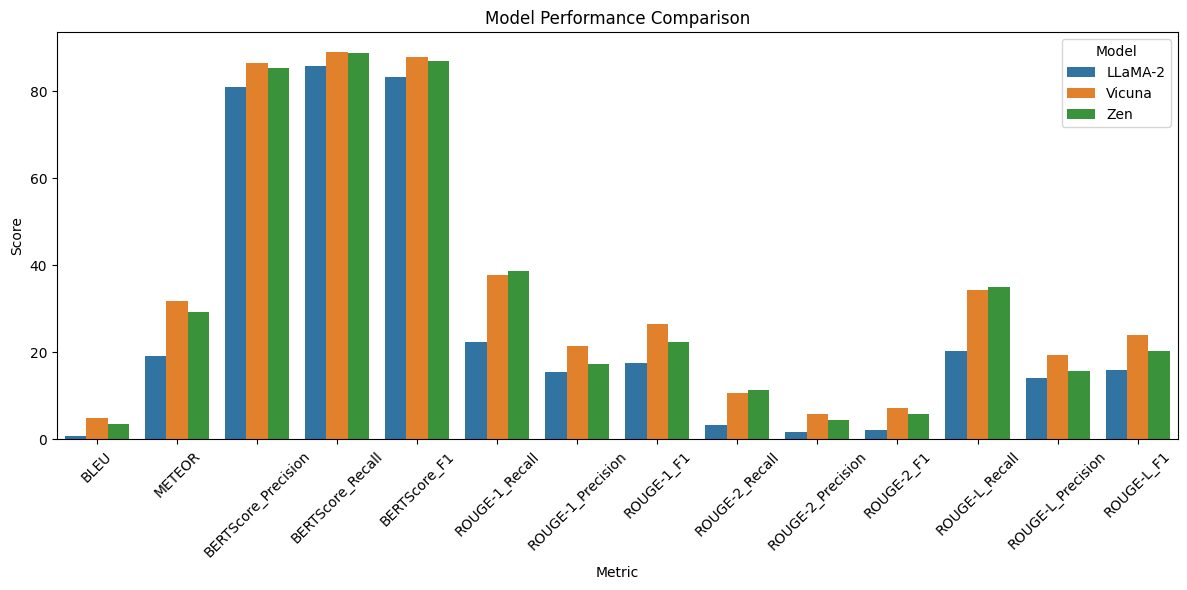

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

score_df2 = score_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score').copy()

# Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=score_df2)

# Customize the plot
plt.xticks(rotation=45)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')

# Show the plot
plt.tight_layout()
plt.show()

In [14]:
import vertexai
from vertexai.preview.language_models import TextGenerationModel
from collections import defaultdict

In [15]:
def predict_large_language_model_sample(
    project_id: str,
    model_name: str,
    temperature: float,
    max_output_tokens: int,
    top_p: float,
    top_k: int,
    content: str,
    location: str = "us-central1",
    tuned_model_name: str = "",
    ) :
    
    vertexai.init(project=project_id, location=location)
    model = TextGenerationModel.from_pretrained(model_name)
    if tuned_model_name:
        model = model.get_tuned_model(tuned_model_name)
    response = model.predict(
        content,
        temperature=temperature,
        max_output_tokens=max_output_tokens,
        top_k=top_k,
        top_p=top_p,)
    return response.text

In [16]:
df.head()

,orig_prompt,answer,Zen,llama-2,vicuna_v1.1,Zen2,Zen3
0,Your name is Zen and you're a mental health co...,It's common to experience low self-esteem at t...,I'm sorry to hear that you're struggling with ...,<</SYS>>\n\nI understand how you feel. It's im...,I'm sorry to hear that you're struggling with ...,"Hi there, it's great that you're taking the fi...",Hey there! I'm sorry to hear that you're strug...
1,Your name is Zen and you're a mental health co...,You too! If you have any concerns or questions...,You too!,[IST]\n<b>My name is</b>\n^i6\n\n[/IST]\n[INST...,"Thank you, have a nice day as well! Is there a...","Thank you, you too!",Thank you! You too!
2,Your name is Zen and you're a mental health co...,It's understandable that you may have difficul...,Thank you for sharing that with me. It takes a...,<</SYS>>\n\nYou're right not to trust people. ...,I understand that it can be difficult to trust...,I understand that it can be difficult to open ...,I understand that it can be difficult to open ...
3,Your name is Zen and you're a mental health co...,Maintaining a healthy work-life balance is imp...,"I see how that can be challenging, and it's im...",<</SYS>>\n\n**Zen** I understand that you're f...,I understand how you feel. It can be challengi...,"Hey there! I totally understand how you feel, ...",It sounds like you're feeling overwhelmed with...
4,Your name is Zen and you're a mental health co...,It's important to communicate openly and hones...,Thank you for reaching out. It's important to ...,<<S>> I'm sorry to hear that. What kind of arg...,I'm sorry to hear that you're having trouble w...,I'm sorry to hear that you're having trouble w...,I'm sorry to hear that you're having trouble w...


In [106]:
index = 0
winners = defaultdict(int)

lw, zw, vw = [], [], []

In [49]:
i, index, winners

(3, 0, defaultdict(int, {}))

In [18]:
import re, time

In [19]:
print(zw)

[3, 10, 13, 14, 15, 16, 19, 22, 24, 25, 26, 30, 38, 40, 42, 43, 44, 46, 60, 63, 65, 68, 73, 74, 77, 79, 82, 85, 86, 87, 89, 91, 94, 96, 100, 108, 113, 116, 118, 119, 124, 127, 131, 137, 138, 139, 140, 141, 146, 150, 153, 155, 158, 161, 162, 163, 165, 168, 169, 173, 174, 175, 181, 182, 183, 185, 186, 188, 190, 192, 193, 194, 195, 197, 199, 201, 202, 206, 213, 215, 216, 217, 223, 224, 225, 227, 229, 232, 235, 237, 244, 248, 249, 254, 256, 257, 259, 260, 261, 262, 263, 265, 270, 271, 274, 277, 279, 286, 289, 293, 297, 301, 309, 311, 314, 318, 322, 331, 332, 335, 337, 338, 339, 344, 345, 346, 352, 354, 356, 361, 367, 371, 374, 377, 378, 383, 386, 387, 391, 394, 397, 399, 402, 403, 405, 409, 411, 415, 416, 421, 422, 426, 430, 435, 438, 447, 454, 457, 458, 462, 463, 464, 465, 467, 471, 472, 474, 477, 480, 481, 482, 485, 486, 493, 495, 499, 500, 506, 508, 516, 521, 522, 525, 527, 534, 535, 536, 539, 540, 541, 542, 546, 547, 550, 551, 554, 556, 559, 560, 564, 571, 578, 582, 591, 592, 593, 597,

In [20]:
print(vw)

[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 17, 18, 20, 21, 23, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 41, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 64, 66, 67, 69, 70, 71, 72, 75, 76, 78, 80, 81, 83, 84, 88, 90, 92, 93, 95, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 114, 115, 117, 120, 121, 122, 123, 125, 126, 128, 129, 130, 132, 133, 134, 135, 136, 142, 143, 144, 145, 147, 148, 149, 151, 152, 154, 156, 157, 159, 160, 164, 166, 167, 170, 171, 172, 176, 177, 178, 179, 180, 184, 187, 189, 191, 196, 198, 200, 203, 204, 205, 207, 208, 209, 210, 211, 212, 214, 218, 219, 220, 221, 222, 226, 228, 230, 231, 233, 234, 236, 238, 239, 240, 241, 242, 243, 245, 246, 247, 250, 251, 252, 253, 255, 258, 264, 266, 267, 268, 269, 272, 273, 275, 276, 278, 280, 281, 282, 283, 284, 285, 287, 288, 290, 291, 292, 294, 295, 296, 298, 299, 300, 302, 303, 304, 305, 306, 307, 308, 310, 312, 313, 315, 316, 317, 319, 320, 321, 323, 324, 325, 326, 327, 328, 329, 330, 333,

In [ ]:
for i in tqdm(range(index, len(df))):
    question = re.findall(r"USER: (.*?) ASSISTANT: ", df.orig_prompt.values[i])[-1].strip()
    llama = df["llama-2"][i]
    vicuna = df["vicuna_v1.1"][i]
    zen = df["Zen3"][i]

    prompt = f"""Below is an excerpt from a conversation between a patient seeking therapeutic guidance and their therapist. You're given a question asked by the patient and three possible answers to this question generated by three different language models LLaMA, Vicuna, and Zen. Your job is to select which response is the best when it comes to therapy. You must choose the best response and judge on the quality of the response rather than the length of the response. Also, judge based on whether the response is more likely to come from a therapist rather than a language model. The more the model sounds like a real therapist better it is. Like is it trying to be more interactive and ask questions to get to the root of the issue? If yes, then that's a good thing. Only reply with model name and nothing else.

### Question
{question}

### LLaMA Response
{llama}

### Vicuna Response
{vicuna}

### Zen Response
{zen}
"""
    text = predict_large_language_model_sample(
        project_id="cloud-lab-ff59", 
        model_name="text-bison", 
        temperature=1.0, 
        max_output_tokens=128,
        top_p=0.8, 
        top_k=40, 
        location="us-central1",
        content=prompt
    ).strip()
    
    text = text.split(",")
    for t in text:
        t = t.strip()
        winners[t] += 1
        if t.lower() == "llama":
            lw.append(i)
        elif t.lower() == "zen":
            zw.append(i)
        elif t.lower() == "vicuna":
            vw.append(i)
        else:
            print(i, text)
    index += 1
    if (index % 50) == 0:
        time.sleep(30)

winners = dict(winners)

  0%|          | 0/314 [00:00<?, ?it/s]

In [110]:
i, index, winners

(437, 438, {'Zen': 430, 'Vicuna': 8})

In [59]:
import numpy as np

In [97]:
rnd = np.random.randint(0, 438, 100)

len([x for x in rnd if x in zw]), len([x for x in rnd if x in vw])

(57, 43)

In [58]:
len([x for x in vw if x > 200]), len([x for x in zw if x > 200])

(134, 103)

In [48]:
i = 3
question = re.findall(r"USER: (.*?) ASSISTANT: ", df.orig_prompt.values[i])[-1].strip()
llama = df["llama-2"][i]
vicuna = df["vicuna_v1.1"][i]
zen = df["Zen3"][i]

prompt = f"""Below is an excerpt from a conversation between a patient seeking therapeutic guidance and their therapist. You're given a question asked by the patient and three possible answers to this question generated by three different language models LLaMA, Vicuna, and Zen. Your job is to select which response is the best when it comes to therapy. You must choose the best response and judge on the quality of the response rather than the length of the response. Only reply with model name and nothing else.

### Question
{question}

### LLaMA Response
{llama}

### Vicuna Response
{vicuna}

### Zen Response
{zen}
"""
print(prompt)

Below is an excerpt from a conversation between a patient seeking therapeutic guidance and their therapist. You're given a question asked by the patient and three possible answers to this question generated by three different language models LLaMA, Vicuna, and Zen. Your job is to select which response is the best when it comes to therapy. You must choose the best response and judge on the quality of the response rather than the length of the response. Only reply with model name and nothing else.

### Question
I'm having trouble with my work-life balance. I feel like I'm always working and never have time for myself.

### LLaMA Response
<</SYS>>

**Zen** I understand that you're feeling like you're always working and never have time for yourself. It's important to make time for yourself, even if it's just for a few minutes each day.

[**C1** I get it. I work for xxx and it seems like I am always at work and never have time for myself. [/INST]
<</SYS>>

**Zen** I'm sorry to hear that you